In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model,ensemble,naive_bayes
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

### Dataset : 
https://archive.ics.uci.edu/ml/machine-learning-databases/adult/

In [2]:
ff = pd.read_csv("adult.csv")

In [3]:
ff.shape

(32561, 15)

In [4]:
ff.dtypes.value_counts()

object    9
int64     6
dtype: int64

In [5]:
ff.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [6]:
inl = ff.isnull().sum()
inl.value_counts()

0    15
dtype: int64

In [7]:
cols_obj = ff.columns[ff.dtypes==object]

In [8]:
cols_non_obj = ff.columns[ff.dtypes!=object]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fba87f57908>,
      dtype=object)

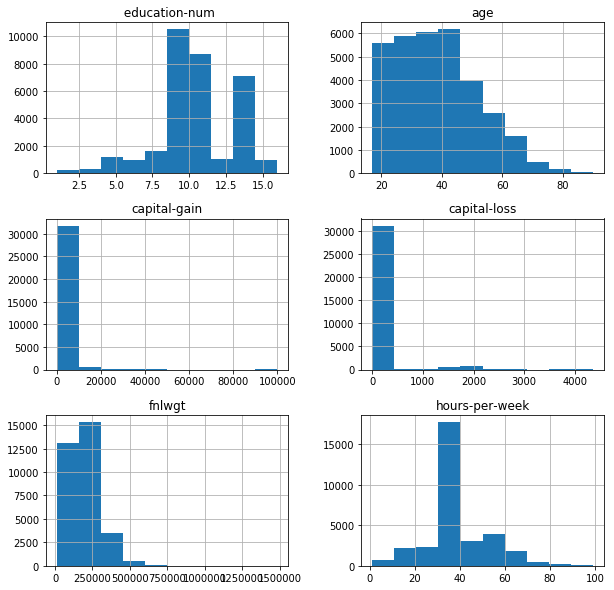

In [9]:
ff.hist(figsize=(10,10))

In [10]:
ff['class_50K'] = ff['class_50K'].map((ff['class_50K'].value_counts() < 10000).astype(int))

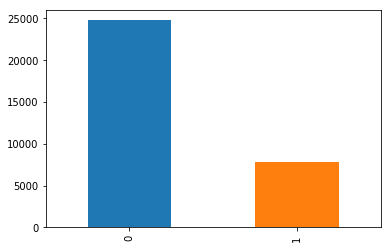

In [11]:
ff['class_50K'].value_counts().plot(kind = 'bar')

### Classes are moderately unbalanced - we'll try to take care of it later.

In [12]:
cols_obj = cols_obj.drop('class_50K')

In [13]:
ff[cols_obj].apply(lambda x: len(x.unique()))

workclass          9
education         16
marital-status     7
occupation        15
relationship       6
race               5
sex                2
native-country    42
dtype: int64

### Convert categorical variables to binary (for both dataframes - with and without outliers)

In [14]:
ff = pd.concat([ff.drop(cols_obj,1), pd.get_dummies(ff[cols_obj])],1)

ff = ff.drop(cols_obj,1)

### Generic function to test different classification models - with and without smote for oversampling:

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from imblearn import over_sampling


def run_model(data,model,oversample = False,confusion=False):
    train,test = train_test_split(data,test_size = 0.3,random_state = 27)
    X = train.drop('class_50K',1)
    y = train['class_50K']
    if oversample:
        smot = over_sampling.BorderlineSMOTE(random_state=12)
        X,y = smot.fit_resample(X,y)
    
    model.fit(X,y)
    print ('AUC : ', roc_auc_score(test['class_50K'],model.predict_proba(test.drop('class_50K',1))[:,1]))
    print ('Accuracy:', model.score(test.drop('class_50K',1),test['class_50K']) )
    if confusion:
        print (confusion_matrix(test['class_50K'],model.predict(test.drop('class_50K',1))))
    return  model

In [16]:
# The linear regression model:
model_lr = run_model(ff,linear_model.LogisticRegression(),confusion=True)

AUC :  0.5919812490655926
Accuracy: 0.80090080868052
[[7218  228]
 [1717  606]]


In [17]:
# Random forests model , with basic hyperparameters tuning:
model_rf = run_model(ff,ensemble.RandomForestClassifier(min_samples_leaf=5),confusion=True)

AUC :  0.9142532793727118
Accuracy: 0.8627290408434845
[[7058  388]
 [ 953 1370]]


In [18]:
# And of course, XGBOOST model:
import xgboost as xgb
model_xgb = run_model(ff,xgb.XGBClassifier(),confusion=True)

AUC :  0.9216384370105021
Accuracy: 0.8669259903777254
[[7084  362]
 [ 938 1385]]


#### Logistic regression fails to classify, while the trees models work quite well.
#### Why Logit fails? we can guess a couple answers - 1. Imbalanced data. 2. Very far from normal feature distributions.
### Logistic regression has one significant advantage over the trees models - it is not a black box, and can easily provide great domain insights. Thus, it's worth the effort to improve it's performance

### Let's try to improve logistic regerssion by 3 differetn strategies: 
1. Transform non-normal distributing features. 

Or, by handling the imbalanced data - either by: 
2. split to small data sets and bag the resulted models   ,or: 
3. over sampling (SMOTE)

#### 1. Log-transform non-normal features:

In [19]:
ff_transpos = ff.copy()
cols_transpos = ['fnlwgt','capital-loss','capital-gain']
ff_transpos[cols_transpos] = ff[cols_transpos].apply(lambda x: np.log(x+1))

In [20]:
model_lr = run_model(ff_transpos,linear_model.LogisticRegression())

AUC :  0.9044545610010675
Accuracy: 0.8478861705394616


### Interesting! using log trnaspose to non-normally distrubting features gave a serious boost to the linear model (i.e. the Logistic regression)!

####  2. Split and bag models
#### The main idea - split, merge and aggregate, as illustrated in the example below: 
* split the 0 class into groups of 4 samples each - same as the 1 class size.
* append each of the three 0 groups with the 1 group -> will result with 3 tables, each has 8 rows of balanced data.
* Apply logistic regression on each table. 
* Apply the 3 models on un-related test set.
* Finally- get the average probability for each sample.

![title](bagging.jpg)

#### Here's the code:

In [21]:
from sklearn.model_selection import KFold
model = linear_model.LogisticRegression()
#model = ensemble.RandomForestClassifier(min_samples_leaf=5)
#model = xgb.XGBClassifier()

train,test = train_test_split(ff,test_size = 0.3,random_state = 27)

train_1 = train[train['class_50K'] ==1]
train_0 = train[train['class_50K'] ==0]
num_group_0 = int(len(train_0)/len(train_1))

# Split the 0 class to N groups, then sample similar size from 1 class (about 80-100% of class 1 size)
kf = KFold(n_splits=num_group_0+3)
vals = {}
for i,h in enumerate(kf.split(X=train_0)):
    trn = train_0.iloc[h[1]].append(train_1.sample(len(h[1])))
    X = trn.drop('class_50K',1)
    y = trn['class_50K']
    model.fit(X,y)
    vals[i] = model.predict_proba(test.drop('class_50K',1))[:,1]

In [22]:
print ('AUC     :' , roc_auc_score(test['class_50K'],pd.DataFrame(vals).mean(1)))
print ('accuracy:', (test['class_50K'].values== (pd.DataFrame(vals).mean(1) > 0.75).astype(int)).sum() / len(test))

AUC     : 0.9018782269215956
accuracy: 0.8537209540382844


### Well, by defining a decision boundary of 0.75 , it improved results as well :)

3. Use Over-sampling with SMOTE (A good summary here : https://www.kaggle.com/qianchao/smote-with-imbalance-data)

In [23]:
from imblearn import over_sampling, under_sampling

In [24]:
model_lr = run_model(ff,linear_model.LogisticRegression(),oversample=True,confusion=True)

AUC :  0.906623773823271
Accuracy: 0.8523902139420616
[[6808  638]
 [ 804 1519]]


### Also Over-sampling worked very well..

## Conclusions : 
### Logistic regression is NOT a black box model which can bring great domain insights.
### Thus, although trees models can provide very quick and easy optimal predictive results, aimed here to improve the logistic regression model through data manipulations.
### Here, on the "adults" dataset, we demonstrated 3 strategies to improve it:
#### 1. Log-transform non-normal features.
#### 2. Overcome imbalanced classes with split-and-bag method.\
#### 3. Overcome imbalanced classes with oversampling (SMOTE)

#### While results seems quite similar, it is worth noting that SMOTE worked here un-usually well, probably because of the abundance of binary variables. These performance are not expected to work as well for continuous variables..